## import library

In [66]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

# df['summary]와 df['keyword']를 python 기반 한국어 토크나이저를 불러와서 토큰화
from konlpy.tag import Okt
from sklearn.decomposition import PCA

In [70]:
# 현재 파일 위치
path = os.getcwd() + '/2-3. 키워드 별 유사도 도출/disclosure/'
with open(os.getcwd() + '/2-3. 키워드 별 유사도 도출/stopwords.txt', 'r', encoding='cp949') as f:
    stopwords = f.readlines()

okt = Okt()

# path 내 파일 리스트 출력
file_list = os.listdir(path)
file_list

['final_test_gs_analysis.csv',
 'final_test_hyun_analysis.csv',
 'final_test_lg_analysis.csv',
 'final_test_lot_analysis.csv',
 'final_test_sin_analysis.csv']

In [72]:
# file_list를 하나의 df로 합치기
df = pd.DataFrame()
for file in file_list:
    df = df.append(pd.read_csv(path + file, index_col=0))

# date 기준으로 정렬
df = df.sort_values(by='date', ascending=False)
df = df.reset_index(drop=True)
# pre_label.1 drop
df = df.drop(['pre_label.1'], axis=1)
# NaN 값 0으로
df = df.fillna(0)

df

C:\Users\MLCF\AppData\Local\Temp\ipykernel_31044\4218083024.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(path + file, index_col=0))
C:\Users\MLCF\AppData\Local\Temp\ipykernel_31044\4218083024.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(path + file, index_col=0))
C:\Users\MLCF\AppData\Local\Temp\ipykernel_31044\4218083024.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(path + file, index_col=0))
C:\Users\MLCF\AppData\Local\Temp\ipykernel_31044\4218083024.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(path + 

,abstract,pre_label,sentiment,score,sent_range,model_keyword,corpus_keyword
0,"“5천원부터 그냥 줍니다” 27만명이나 챙긴 ‘용돈벌이’ 몰랐어? [지구, 뭐......",1,0,2.529453,보통부정,갤러리아백화점 롯데백화점,
1,"쏘카, 롯데하이마트와 탄소배출 절감·모빌리티 활성화 맞손 쏘카가 온·오프라인 서비스...",0,0,4.046216,보통부정,0,0
2,대기업들 설 상생...협력사 납품대금 앞당겨 지급 또한 GS리테일은 가맹점 경영주와...,0,0,3.475096,보통부정,0,0
3,LG유플러스 또 고객 정보 유출… 경찰 수사 착수 ★GS리테일 판촉비용 전가로 16...,0,1,2.050638,중립,0,0
4,"CJ제일제당, 배당·성과급 미스매치…해외사업·CJ대한통운 걸림돌 이외에도 SK하이닉...",0,0,2.454978,약한부정,0,0
...,...,...,...,...,...,...,...
11871,"정용진 신세계그룹 부회장, ""머리 아닌 심장으로 생각하라""....'제2의 월마트.....",0,1,1.931253,중립,0,0
11872,"GS리테일, New Vision 선포 및 2022년 경영전략 밝표 허연수 GS리테일...",0,1,2.050638,중립,0,0
11873,저주받은 색조 양극화 기초 화장품 훨훨 [사진=LG생활건강] 비건 화장품 인기 세계...,0,0,2.175585,약한부정,0,0
11874,"GS샵, '신년맞이 특가여행' 제주신화월드 메리어트관 단독 판매 테마파크, 워터파크...",0,0,3.644483,강한부정,0,0


In [73]:
def plot_2d_graph(vocabs, xs, ys):
    plt.figure(figsize=(8 ,6))
    plt.scatter(xs, ys, marker = 'o')
    for i, v in enumerate(vocabs):
        plt.annotate(v, xy=(xs[i], ys[i]))

# 한글폰트 세팅
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [74]:
#df = pd.read_csv(path + file_list[5], encoding='cp949')


# df의 label 별로 df 생성하는 for문
#    for i in range(len(esg_word)):
df_1 = df[df['pre_label'] == '1']
df_1 = df_1.reset_index(drop=True)

df_2 = df[df['pre_label'] == '2']
df_2 = df_2.reset_index(drop=True)

df_3 = df[df['pre_label'] == '3']
df_3 = df_3.reset_index(drop=True)


### E에 대한 키워드 유사도

In [59]:
df_1['agg'] = df_1['summary'] + df_1['keyword']

# sumarry와 keyword를 합쳐서 토큰화
tokenized_doc = df_1['agg'].apply(lambda x: okt.morphs(x, stem=True)) # 토큰화
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stopwords]) # 불용어 제거

# keyword에 대해서만 word embedding을 위해 단어 추출 및 통합 과정
split_word = df_1['keyword'].apply(lambda x: okt.morphs(x, stem=True))
# split_word의 각 행의 첫 번째, 두 번째 단어 뽑기
split_word = split_word.apply(lambda x: x[:2])
# split_word의 각 행의 단어 합치기
split_word_agg = split_word.apply(lambda x: ' '.join(x))

# tokenized_doc에 구분된 keyword 단어에 대해 다시 합치기
for j in range(len(tokenized_doc)):
    tokenized_doc = tokenized_doc.apply(lambda x: [split_word_agg[j] if item == split_word[j][0] or item == split_word[j][1] else item for item in x])

# model 정의 : sg = 0은 CBOW, sg = 1은 Skip-gram
model = Word2Vec(tokenized_doc, vector_size=100, window=5, min_count=1, workers=4, sg = 1)
word_vectors = model.wv

vocabs = split_word_agg.tolist()
word_vectors_list = [word_vectors[v] for v in vocabs]

pca = PCA(n_components=2)
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys = xys[:,1]

# 결과
plot_2d_graph(vocabs, xs, ys)

# word_vectors npy로 저장
import numpy as np

output_path = os.getcwd() + '/disclosure/output/' + file_list[1] + '/e/'

if not os.path.exists(output_path):
    os.makedirs(output_path)
    
np.save(output_path + 'word_vectors.npy', word_vectors_list)
np.save(output_path + 'vocabs.npy', vocabs)

IndexError: list index out of range

### S에 대한 키워드 유사도

['협력 방송', '안전 보건', '투명 거래', '협력 관리', '품질 관리', '제품 점검', '방송 법', '임 직원', '위험 평가', '파트너 경영', '임 직원', '전문 심사', '중소 협력', '분쟁 조정', '교육 지원', '화학 물질', '품질 관리', '중소기업 수출', '거래 계약', '재계약 지', '행사 지원', '자금 지원', '공정 거래', '근로자 안전', '소통 제도', '상품 모니터링', '품질 관리', '품질 관리', '정보 보안', '정보 보호', '개인정보 관리', '안전 보건', '동반 성장', '총회 협력', '점검 프로', '협력 회사', '구성원 건강', '품질 관리', '경영 내부통제', '품질 인증', '안전 보건관리', '산업 안전', '교류 활동', '파트너 개발', '품질 관리', '윤리 진단', '역량 컨설팅', '여성 임원', '자율 준수', '안전 준법', '고객 대상', '협력 관계', '매장 환경', '중소기업 판로', '공정 거래', '임 직원', '지인 거래', '임 직원']


c:\Users\MLCF\anaconda3\envs\bk\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


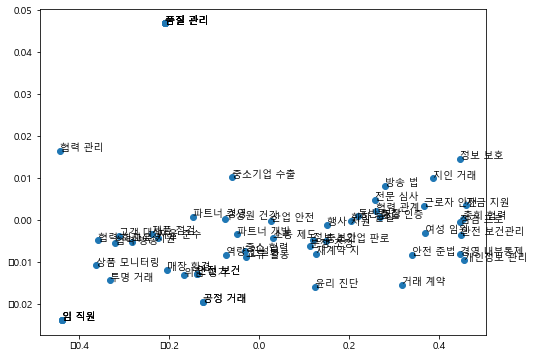

In [64]:
df_2['agg'] = df_2['summary'] + df_2['keyword']

# sumarry와 keyword를 합쳐서 토큰화
tokenized_doc = df_2['agg'].apply(lambda x: okt.morphs(x, stem=True)) # 토큰화
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stopwords]) # 불용어 제거

# keyword에 대해서만 word embedding을 위해 단어 추출 및 통합 과정
split_word = df_2['keyword'].apply(lambda x: okt.morphs(x, stem=True))

# split_word의 각 행의 첫 번째, 두 번째 단어 뽑기
split_word = split_word.apply(lambda x: x[:2])

# split_word의 각 행의 단어 합치기
split_word_agg = split_word.apply(lambda x: ' '.join(x))

# tokenized_doc에 구분된 keyword 단어에 대해 다시 합치기
for j in range(len(tokenized_doc)):
    tokenized_doc = tokenized_doc.apply(lambda x: [split_word_agg[j] if item == split_word[j][0] or item == split_word[j][1] else item for item in x])

# model 정의 : sg = 0은 CBOW, sg = 1은 Skip-gram
model = Word2Vec(tokenized_doc, vector_size=100, window=5, min_count=1, workers=4, sg = 1)
word_vectors = model.wv

vocabs = ['협력 방송', '안전 보건', '투명 거래', '협력 관리', '품질 관리', '제품 점검', '방송 법', '임 직원', '위험 평가', '파트너 경영', '임 직원', '전문 심사', '중소 협력', '분쟁 조정', '교육 지원', '화학 물질', '품질 관리', '중소기업 수출', '거래 계약', '재계약 지', '행사 지원', '자금 지원', '공정 거래', '근로자 안전', '소통 제도', '상품 모니터링', '품질 관리', '품질 관리', '정보 보안', '정보 보호', '개인정보 관리', '안전 보건', '동반 성장', '총회 협력', '점검 프로', '협력 회사', '구성원 건강', '품질 관리', '경영 내부통제', '품질 인증', '안전 보건관리', '산업 안전', '교류 활동', '파트너 개발', '품질 관리', '윤리 진단', '역량 컨설팅', '여성 임원', '자율 준수', '안전 준법', '고객 대상', '협력 관계', '매장 환경',  '중소기업 판로', '공정 거래', '임 직원', '지인 거래', '임 직원']
print(vocabs)
word_vectors_list = [word_vectors[v] for v in vocabs]
pca = PCA(n_components=2)
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys = xys[:,1]

# 결과
plot_2d_graph(vocabs, xs, ys)

output_path = os.getcwd() + '/disclosure/output/' + file_list[5] + '/s/'

if not os.path.exists(output_path):
    os.makedirs(output_path)
    
np.save(output_path + 'word_vectors.npy', word_vectors_list)
np.save(output_path + 'vocabs.npy', vocabs)

### G에 대한 키워드 유사도

In [62]:
df_3['agg'] = df_3['summary'] + df_3['keyword']

print(df_3['agg'])
# sumarry와 keyword를 합쳐서 토큰화
tokenized_doc = df_3['agg'].apply(lambda x: okt.morphs(x, stem=True)) # 토큰화
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stopwords]) # 불용어 제거

# keyword에 대해서만 word embedding을 위해 단어 추출 및 통합 과정
split_word = df_3['keyword'].apply(lambda x: okt.morphs(x, stem=True))

# split_word의 각 행의 첫 번째, 두 번째 단어 뽑기
split_word = split_word.apply(lambda x: x[:2])

# split_word의 각 행의 단어 합치기
split_word_agg = split_word.apply(lambda x: ' '.join(x))

# tokenized_doc에 구분된 keyword 단어에 대해 다시 합치기
for j in range(len(tokenized_doc)):
    tokenized_doc = tokenized_doc.apply(lambda x: [split_word_agg[j] if item == split_word[j][0] or item == split_word[j][1] else item for item in x])

# model 정의 : sg = 0은 CBOW, sg = 1은 Skip-gram
model = Word2Vec(tokenized_doc, vector_size=100, window=5, min_count=1, workers=4, sg = 1)
word_vectors = model.wv

vocabs = split_word_agg.tolist()
word_vectors_list = [word_vectors[v] for v in vocabs]

pca = PCA(n_components=2)
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys = xys[:,1]

# 결과
plot_2d_graph(vocabs, xs, ys)

output_path = os.getcwd() + '/disclosure/output/' + file_list[1] + '/g/'

if not os.path.exists(output_path):
    os.makedirs(output_path)
    
np.save(output_path + 'word_vectors.npy', word_vectors_list)
np.save(output_path + 'vocabs.npy', vocabs)

0    현대홈쇼핑은 건전하고 투명한 지배구조 확립에 대한 의지 공표 및 주주 등 모든 이해...
Name: agg, dtype: object


ValueError: n_components=2 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'